# SODA 3.4.2 Data
Bottom Temperature and Salinity to compare with SOSE and WOA products

In [1]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(10)
#cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

In [2]:
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-staging-dask-gateway.staging:80/staging.a3e8d6aa3c364f9ca930a8d94148ad88 Dashboard: /services/dask-gateway/clusters/staging.a3e8d6aa3c364f9ca930a8d94148ad88/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [11]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import xmitgcm
import xgcm
xr.set_options(display_style='text')

In [4]:
url_ocean = 'gs://pangeo-forge-us-central1/pangeo-forge/soda/soda3.4.2_5dy_ocean_or'
fs = gcsfs.GCSFileSystem()
ocean = xr.open_zarr(fs.get_mapper(url_ocean), consolidated=True, decode_times=False)

with fs.open('gs://pangeo-tmp/stb2145/SODA/datasets/topog.nc') as fp:
    topo = xr.open_dataset(fp)

In [5]:
#fix time dim (1898/1897 indices are 1980-01-01)
test_time = xr.cftime_range('1993-01-04 13:00:00', freq='5D', periods=1970, calendar='julian')
ocean_test = ocean.copy()
ocean_test = ocean.assign_coords(coords={'time': test_time})
#ocean_test = ocean.assign_attrs(ocean.time.attrs)
ocean['time'] = ocean_test.time

## <font color='Green'>Slice to WG region</font>

In [6]:
#WG boundaries (80˚S, 62˚S, 65˚W, 30˚E)
lower_lat = 0 #-80.02101494
upper_lat = 169 #-62.01972704
left_lon =  859 #-65.12
right_lon = 1240 #30.12

lower_lat_u = 0 #-79.96821565
upper_lat_u = 169 #-61.96096874 python is right exclusive so will have -62.0 in array
left_lon_u = 859 #-65.0
right_lon_u = 1240 #30.25 python is right exclusive so will have 30.0˚E

In [43]:
#set the boundaries
lat_range = dict(yt_ocean=slice(lower_lat, upper_lat), yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range = dict(xt_ocean=slice(left_lon, right_lon), xu_ocean=slice(left_lon_u, right_lon_u))

lat_range_no_u = dict(yt_ocean=slice(lower_lat, upper_lat))
lon_range_no_u = dict(xt_ocean=slice(left_lon, right_lon))

lat_range_u = dict(yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range_u = dict(xu_ocean=slice(left_lon_u, right_lon_u))

lat_range_top = dict(grid_y_T=slice(lower_lat, upper_lat))
lon_range_top = dict(grid_x_T=slice(left_lon, right_lon))

In [65]:
topo.ds_10_12_T#.max()

<xarray.DataArray 'ds_10_12_T' (grid_y_T: 1070, grid_x_T: 1440)>
array([[11742.02738 , 11742.02738 , 11742.02738 , ..., 11742.02738 ,
        11742.02738 , 11742.02738 ],
       [11742.02738 , 11742.02738 , 11742.02738 , ..., 11742.02738 ,
        11742.02738 , 11742.02738 ],
       [11742.02738 , 11742.02738 , 11742.02738 , ..., 11742.02738 ,
        11742.02738 , 11742.02738 ],
       ...,
       [   48.727646,   145.607598,   241.726427, ...,   241.726427,
          145.607598,    48.727646],
       [   48.730827,   145.617022,   241.741943, ...,   241.741943,
          145.617022,    48.730827],
       [   48.694749,   145.509175,   241.562838, ...,   241.562838,
          145.509175,    48.694749]])
Coordinates:
  * grid_x_T  (grid_x_T) float32 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * grid_y_T  (grid_y_T) float32 -80.02 -79.92 -79.81 ... 89.74 89.84 89.95
Attributes:
    long_name:  height of T_cell
    units:      m

In [36]:
topo.depth.max()

<xarray.DataArray 'depth' ()>
array(5500.)

In [61]:
topo.depth

<xarray.DataArray 'depth' (grid_y_T: 1070, grid_x_T: 1440)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * grid_x_T  (grid_x_T) float32 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * grid_y_T  (grid_y_T) float32 -80.02 -79.92 -79.81 ... 89.74 89.84 89.95
Attributes:
    long_name:  topographic depth of T-cell
    units:      meters

In [51]:
ds_wg = ocean.isel(**lat_range, **lon_range)
depth_wg = topo.depth.isel(**lat_range_top, **lon_range_top)

In [ ]:
mask = ds_wg.time != ds_wg.time.sel(time='2018-12-24').values
salt_mask = ds_wg.salt.where(mask)#.load()
temp_mask = ds_wg.temp.where(mask)#.load()

In [ ]:
#testing to see if correctly sliced desired region
sst_mean = ds_wg.temp.isel(st_ocean=0).mean(dim='time')
sst_mean.plot()

## <span style='color:Red'> Bottom Potential Temperatures

In [ ]:
grid_transport = xgcm.Grid(ds_wg, coords={'X': {'center': 'xt_ocean', 'right': 'xu_ocean'}, 
                                              'Y': {'center': 'yt_ocean', 'right': 'yu_ocean'},
                                              'T': {'center': 'time'},
                                              'Z': {'center': 'st_edges_ocean', 'right': 'st_ocean'},
                                              'Zu': {'center': 'sw_edges_ocean', 'right': 'sw_ocean'}},
                     periodic=['X'])
grid_transport

In [57]:
#this gives us the depth of the bottom cell
depth_max = ds_wg.st_ocean.where(depth_wg.max()).max(dim='st_ocean').load()

In [69]:
ds_wg.temp.shape

(1970, 50, 169, 381)

In [70]:
depth_wg.shape

(169, 381)

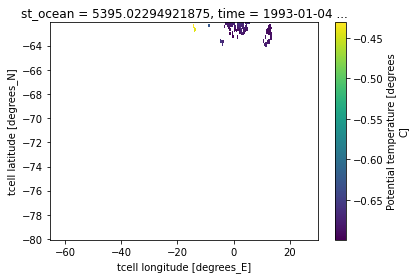

In [81]:
ds_wg.temp[0,-1,:,:].plot()

In [1]:
ds_wg.temp.st_ocean.max()

NameError: name 'ds_wg' is not defined

In [ ]:
ds_wg.temp.where(ds_wg.temp.notnull() & ds_wg.temp.st_ocean.max())

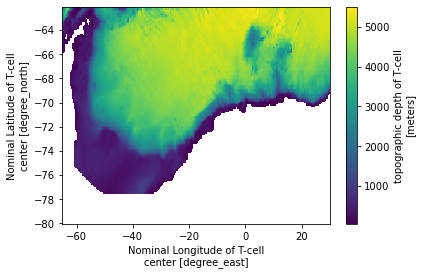

In [63]:
depth_wg.plot()

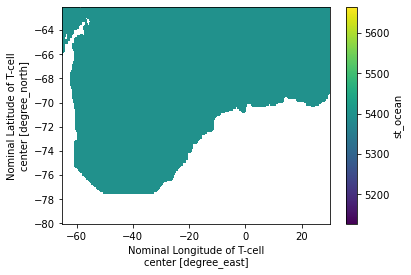

In [59]:
depth_max.plot()

In [60]:
bottom_temp = ds_wg.temp.sel(st_ocean=depth_max)#.fillna(0.).astype('i4'))
bottom_temp

KeyError: "not all values found in index 'st_ocean'"

## <span style='color:Red'> Bottom Temperature Standard Deviation (start)

## <span style='color:Red'> Bottom Temperature Standard Deviation (end)